# 1、初始化模型

In [4]:
from langchain_openai import ChatOpenAI
import os, dotenv

dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_BASE_URL"] = os.getenv("OPENAI_BASE_URL")

llm = ChatOpenAI(model="gpt-5-mini")

# 2、LLM功能增强
给大模型添加工具调用、结构化输出、记忆能力等

In [5]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[]

# 3、提示链（PromptChaining）
在LangGraph框架中，Prompt Chaining（提示链） 是一种将复杂任务拆解为多个连续步骤的设计模式，其中前一步大语言模型（LLM）的输出，会作为下一步的输入。



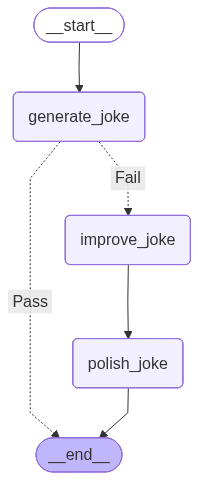

初始的笑话:
疯狂动物城一家快餐店推出了两个新套餐：  
“食肉者套餐”和“素食者套餐”。一只羊大胆地点了食肉者套餐，收银员惊讶地问：“你确定要吃肉吗？”  
羊淡定地说：“当然——我的朋友是狮子，他请客。”

--- --- ---

final_joke:
疯狂动物城一家快餐店推出了两个新套餐：  
“食肉者套餐”和“素食者套餐”。一只羊大胆地点了食肉者套餐，收银员惊讶地问：“你确定要吃肉吗？”  
羊淡定地说：“当然——我的朋友是狮子，他请客。”


In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 定义Graph状态数据结构
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# 定义节点
def generate_joke(state: State):
    """第一次LLM调用，生成初始的笑话"""

    msg = llm.invoke(f"编写一个关于{state["topic"]}主题的笑话")
    return {"joke": msg.content}


def check_punchline(state: State):
    """检查笑话是否具备笑点"""

    # 这里做简单的检查：判断笑话中是否包含？或者！
    if "？" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    else:
        return "Fail"


def improve_joke(state: State):
    """第二次LLM调用来改善笑话"""

    msg = llm.invoke(f"通过添加“谐音梗“来让下面这个笑话更加有趣一些\n笑话: {state["joke"]}")
    return {"improved_joke": msg.content}

def polish_joke(state:State):
    """第三次LLM调用来获取最终的笑话"""

    msg = llm.invoke(f"给当前这个笑话添加一个让人感到惊奇的转折\n笑话: {state["improved_joke"]}")
    return {"final_joke": msg.content}

# 构建工作流
workflow = StateGraph(State)

# 添加节点
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# 添加边，连接这些节点
workflow.add_edge(START, "generate_joke")
# 添加条件边，根据不同条件跳转到不同节点
workflow.add_conditional_edges("generate_joke", check_punchline, {"Pass": END, "Fail": "improve_joke"})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# 编译图
chain = workflow.compile()

# 展示工作流
display(Image(chain.get_graph().draw_mermaid_png()))

# 调用结果
state = chain.invoke({"topic": "疯狂动物城"})
print(f"初始的笑话:\n{state["joke"]}")
print("\n--- --- ---\n")
if "improve_joke" in state:
    print(f"improved_joke:\n{state["improved_joke"]}")
    print("\n--- --- ---\n")
    print(f"final_joke:\n{state["final_joke"]}")
else:
    print(f"final_joke:\n{state["joke"]}")

